# Deep learning for computer vision


This notebook will teach you to build and train convolutional networks for image recognition. Brace yourselves.

# CIFAR dataset
This week, we shall focus on the image recognition problem on cifar10 dataset
* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

<img src="cifar10.jpg" style="width:80%">

In [1]:
import numpy as np
from cifar import load_cifar10
X_train,y_train,X_val,y_val,X_test,y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape,y_train.shape)

Dataset not found. Downloading...
(40000, 3, 32, 32) (40000,)


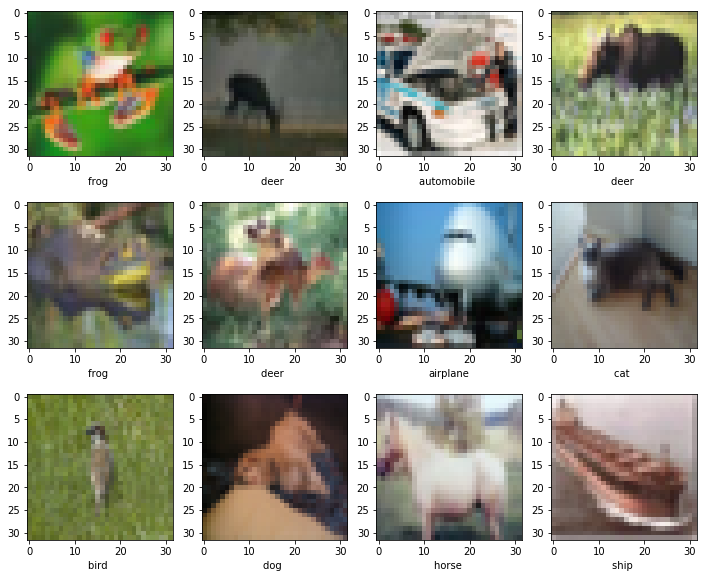

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i],[1,2,0]))

# Building a network

Simple neural networks with layers applied on top of one another can be implemented as `torch.nn.Sequential` - just add a list of pre-built modules and let it train.

In [3]:
import torch, torch.nn as nn
import torch.nn.functional as F

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

Let's start with a dense network for our baseline:

In [4]:
model = nn.Sequential()

# reshape from "images" to flat vectors
model.add_module('flatten', Flatten())

# dense "head"
model.add_module('dense1', nn.Linear(3 * 32 * 32, 64))
model.add_module('dense1_relu', nn.ReLU())
model.add_module('dense2_logits', nn.Linear(64, 10)) # logits for 10 classes

As in our basic tutorial, we train our model with negative log-likelihood aka crossentropy.

In [5]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.FloatTensor(X_batch)
    y_batch = torch.LongTensor(y_batch)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [6]:
# example
compute_loss(X_train[:5], y_train[:5])

tensor(2.2123, grad_fn=<MeanBackward1>)

### Training on minibatches
* We got 40k images, that's way too many for a full-batch SGD. Let's train on minibatches instead
* Below is a function that splits the training sample into minibatches

In [7]:
# An auxilary function that returns mini-batches for neural network training
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [8]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss = []
val_accuracy = []

In [10]:
import time
num_epochs = 100 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.item())
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.FloatTensor(X_batch))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 100 took 1.387s
  training loss (in-iteration): 	2.039060
  validation accuracy: 			34.83 %
Epoch 2 of 100 took 1.226s
  training loss (in-iteration): 	1.861752
  validation accuracy: 			37.07 %
Epoch 3 of 100 took 1.154s
  training loss (in-iteration): 	1.797453
  validation accuracy: 			37.49 %
Epoch 4 of 100 took 1.130s
  training loss (in-iteration): 	1.749105
  validation accuracy: 			38.71 %
Epoch 5 of 100 took 1.139s
  training loss (in-iteration): 	1.709471
  validation accuracy: 			39.86 %
Epoch 6 of 100 took 1.128s
  training loss (in-iteration): 	1.678090
  validation accuracy: 			40.71 %
Epoch 7 of 100 took 1.164s
  training loss (in-iteration): 	1.646244
  validation accuracy: 			42.75 %
Epoch 8 of 100 took 1.136s
  training loss (in-iteration): 	1.624328
  validation accuracy: 			43.65 %
Epoch 9 of 100 took 1.160s
  training loss (in-iteration): 	1.601658
  validation accuracy: 			43.75 %
Epoch 10 of 100 took 1.157s
  training loss (in-iteration): 	1.579629
  v

KeyboardInterrupt: 

Don't wait for full 100 epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.
```

```

```

```

```

```

```

```

```

```

### Final test

In [12]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.FloatTensor(X_batch))
    y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'19. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		48.34 %
We need more magic! Follow instructons below


## Task I: small convolution net
### First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 10 filters and _ReLU_ activation
* 2x2 pooling (or set previous convolution stride to 3)
* Flatten
* Dense layer with 100 neurons and _ReLU_ activation
* 10% dropout
* Output dense layer.


__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with default params (feel free to modify the code above).

If everything is right, you should get at least __50%__ validation accuracy.

In [19]:
model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            Flatten(),
            nn.Linear(2250, 100),
            nn.ReLU(),
            nn.Dropout(p=.1),
            nn.Linear(100, 10)
        ).cuda()

In [20]:
opt = torch.optim.Adam(model.parameters())

train_loss = []
val_accuracy = []

In [21]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.cuda.FloatTensor(X_batch)
    y_batch = torch.cuda.LongTensor(y_batch)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).cuda().mean()

In [22]:
num_epochs = 100 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.item())
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.cuda.FloatTensor(X_batch))
        y_pred = logits.max(1)[1].cpu().numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 100 took 2.056s
  training loss (in-iteration): 	1.700887
  validation accuracy: 			47.91 %
Epoch 2 of 100 took 1.700s
  training loss (in-iteration): 	1.422721
  validation accuracy: 			52.03 %
Epoch 3 of 100 took 1.814s
  training loss (in-iteration): 	1.329852
  validation accuracy: 			54.22 %
Epoch 4 of 100 took 1.791s
  training loss (in-iteration): 	1.255816
  validation accuracy: 			56.63 %
Epoch 5 of 100 took 1.793s
  training loss (in-iteration): 	1.192760
  validation accuracy: 			58.12 %
Epoch 6 of 100 took 1.820s
  training loss (in-iteration): 	1.145264
  validation accuracy: 			58.80 %
Epoch 7 of 100 took 1.732s
  training loss (in-iteration): 	1.098491
  validation accuracy: 			60.19 %
Epoch 8 of 100 took 1.722s
  training loss (in-iteration): 	1.056379
  validation accuracy: 			60.54 %
Epoch 9 of 100 took 1.804s
  training loss (in-iteration): 	1.024523
  validation accuracy: 			60.08 %
Epoch 10 of 100 took 1.751s
  training loss (in-iteration): 	0.994005
  v

KeyboardInterrupt: 

In [23]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.cuda.FloatTensor(X_batch))
    y_pred = logits.max(1)[1].cpu().data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'19. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		59.80 %
Achievement unlocked: 60lvl Warlock!


```

```

```

```

```

```

```

```

```

```

__Hint:__ If you don't want to compute shapes by hand, just plug in any shape (e.g. 1 unit) and run compute_loss. You will see something like this:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__

See the __1960__ there? That's your actual input shape.

## Task 2: adding normalization

* Add batch norm (with default params) between convolution and ReLU
  * nn.BatchNorm*d (1d for dense, 2d for conv)
  * usually better to put them after linear/conv but before nonlinearity
* Re-train the network with the same optimizer, it should get at least 60% validation accuracy at peak.



In [24]:
model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            Flatten(),
            nn.Linear(2250, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Dropout(p=.1),
            nn.Linear(100, 10)
        ).cuda()

In [25]:
opt = torch.optim.Adam(model.parameters())

train_loss = []
val_accuracy = []

In [26]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.cuda.FloatTensor(X_batch)
    y_batch = torch.cuda.LongTensor(y_batch)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).cuda().mean()

In [27]:
num_epochs = 100 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.item())
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.cuda.FloatTensor(X_batch))
        y_pred = logits.max(1)[1].cpu().numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 100 took 2.446s
  training loss (in-iteration): 	1.421023
  validation accuracy: 			55.20 %
Epoch 2 of 100 took 2.346s
  training loss (in-iteration): 	1.136393
  validation accuracy: 			59.50 %
Epoch 3 of 100 took 2.327s
  training loss (in-iteration): 	1.023103
  validation accuracy: 			58.44 %
Epoch 4 of 100 took 2.329s
  training loss (in-iteration): 	0.934671
  validation accuracy: 			60.42 %
Epoch 5 of 100 took 2.339s
  training loss (in-iteration): 	0.859028
  validation accuracy: 			58.36 %
Epoch 6 of 100 took 2.303s
  training loss (in-iteration): 	0.793012
  validation accuracy: 			62.70 %
Epoch 7 of 100 took 2.195s
  training loss (in-iteration): 	0.731171
  validation accuracy: 			60.64 %
Epoch 8 of 100 took 2.357s
  training loss (in-iteration): 	0.675830
  validation accuracy: 			58.38 %
Epoch 9 of 100 took 2.365s
  training loss (in-iteration): 	0.633040
  validation accuracy: 			61.94 %
Epoch 10 of 100 took 2.203s
  training loss (in-iteration): 	0.587947
  v

KeyboardInterrupt: 

In [28]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.cuda.FloatTensor(X_batch))
    y_pred = logits.max(1)[1].cpu().data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'19. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		58.41 %
Achievement unlocked: 60lvl Warlock!



```

```

```

```

```

```

```

```

```

```

```

```

```

```
## Task 3: Data Augmentation

There's a powerful torch tool for image preprocessing useful to do data preprocessing and augmentation.

Here's how it works: we define a pipeline that
* makes random crops of data (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)

In [29]:
from torchvision import transforms
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

transform_augment = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation([-30, 30]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

In [30]:
from torchvision.datasets import CIFAR10
train_loader = CIFAR10("./cifar_data/", train=True, transform=transform_augment)

train_batch_gen = torch.utils.data.DataLoader(train_loader, 
                                              batch_size=32,
                                              shuffle=True,
                                              num_workers=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


X: <class 'torch.Tensor'> torch.Size([32, 3, 32, 32])
y: <class 'torch.Tensor'> torch.Size([32])


NotImplementedError: Plese use this code in your training loop

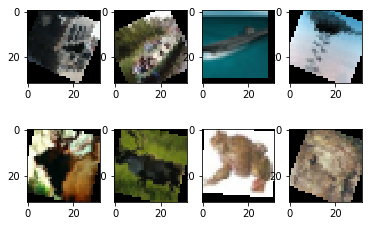

In [31]:
for (x_batch, y_batch) in train_batch_gen:
    
    print('X:', type(x_batch), x_batch.shape)
    print('y:', type(y_batch), y_batch.shape)
    
    for i, img in enumerate(x_batch.numpy()[:8]):
        plt.subplot(2, 4, i+1)
        plt.imshow(img.transpose([1,2,0]) * stds + means )
        
    
    raise NotImplementedError("Plese use this code in your training loop")
    # TODO use this in your training loop

In [32]:
model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            Flatten(),
            nn.Linear(2250, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Dropout(p=.1),
            nn.Linear(100, 10)
        ).cuda()

In [33]:
opt        = torch.optim.Adam(model.parameters())
train_loss = []

In [38]:
num_epochs = 100 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior

    for (x_batch, y_batch) in train_batch_gen:
        loss = compute_loss(x_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.item())
        
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))

Epoch 1 of 100 took 16.410s
  training loss (in-iteration): 	1.552483
Epoch 2 of 100 took 16.430s
  training loss (in-iteration): 	1.487657
Epoch 3 of 100 took 16.633s
  training loss (in-iteration): 	1.436196
Epoch 4 of 100 took 16.231s
  training loss (in-iteration): 	1.411057
Epoch 5 of 100 took 17.457s
  training loss (in-iteration): 	1.397780
Epoch 6 of 100 took 16.671s
  training loss (in-iteration): 	1.378863
Epoch 7 of 100 took 16.523s
  training loss (in-iteration): 	1.350598
Epoch 8 of 100 took 16.833s
  training loss (in-iteration): 	1.341079
Epoch 9 of 100 took 16.455s
  training loss (in-iteration): 	1.326663
Epoch 10 of 100 took 16.922s
  training loss (in-iteration): 	1.324184
Epoch 11 of 100 took 16.269s
  training loss (in-iteration): 	1.308774
Epoch 12 of 100 took 16.333s
  training loss (in-iteration): 	1.314438
Epoch 13 of 100 took 16.429s
  training loss (in-iteration): 	1.297107
Epoch 14 of 100 took 16.665s
  training loss (in-iteration): 	1.294938
Epoch 15 of 100

KeyboardInterrupt: 

When testing, we don't need random crops, just normalize with same statistics.

In [47]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

test_loader = CIFAR10("./cifar_data/", train=False, transform=transform_test)

test_batch_gen = torch.utils.data.DataLoader(test_loader, 
                                             batch_size=32,
                                             shuffle=False,
                                             num_workers=8)

In [54]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []

for (x_batch, y_batch) in test_batch_gen:
    logits = model(x_batch.to('cuda'))
    y_pred = logits.max(1)[1].cpu().data.numpy()
    test_batch_acc.append(np.mean(y_batch.numpy() == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'19. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		61.88 %
Achievement unlocked: 70lvl Warlock!


## The Quest For A Better Network

See `practical_dl/homework02` for a full-scale assignment.